In [15]:
# calculate kiwifruit 's each parts' mua, mus, with equal scale enlarge
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
import scipy as scipy
from scipy.optimize import minimize
# from scipy import signal
# from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import os
import gc

In [14]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )

        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [12]:
dict0 = {}
for i in range(1,100):
    dict0[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230211\\常温\\Sample'+str(i)+'.txt'
dict0[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230211\\常温\\irf00.txt'


In [25]:
files = os.listdir(dict0[0][0:-10])   # 读入文件夹
N = len(files)       # 统计文件夹中的文件个数
scat = [None]*N
data_480multi9 = np.zeros((N,480), dtype = float)
time_index = np.zeros((N,480))
j=0
for i in range(0,100):
    if os.path.exists(dict0[i]):
        scat[j] = process_hyperspec(dict0[i], i)
        scat[j].read_data()
        data_480multi9[j,:] = scat[j].cal_846nm()
        time_index[j] = scat[j].return_dataframe().index
        j=j+1
    else:
        pass
# ##############################################
# str0 = '['
# for i in range(N):
#     str0 = str0 +'line['+str(i)+'],'

# str0 = str0[0:-1]
# str0 = str0+']'
# ###############################################
# #########################################
# str1 = '['
# for i in range(N):
#     str1 = str1 + '\''+eval('dict0')[i][12:-4]+'\''+','

# str1 = str1+']'
# ###############################################
# line = [None]*N
# plt.figure(figsize = (5,5))
# for i in range(0,N):
#     line[i], = plt.plot(time_index[i],data_480multi9[i,:])

# plt.legend(handles=eval(str0)
#            ,labels=eval(str1),loc='best')
# plt.show()
    

In [31]:
kernel0 = np.ones((10,))
data_smooth = np.zeros((N-1,480))
for i in range(N-1):
    data_smooth[i] = np.convolve(kernel0,data_480multi9[i+1],'same')/np.sum(kernel0)
y = np.zeros((data_smooth.shape[0],data_smooth.shape[1]*2-1))
y[:,0:data_smooth.shape[1]] = data_smooth
h = np.convolve(kernel0,data_480multi9[0],'same')/np.sum(kernel0)

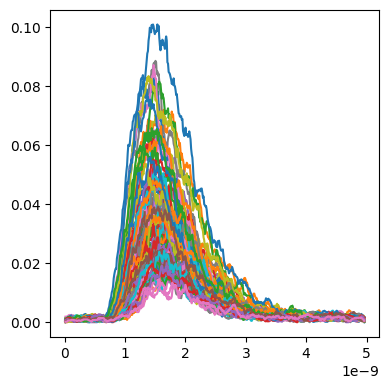

In [33]:
##########################################
fig = plt.figure(figsize = (4,4))
# plt.subplot(1,2,2)
# for i in range(1,N):
#     plt.plot(time_index[i]*1e-9,data_480multi9[i])
# plt.subplot(1,2,1)
for i in range(0,y.shape[0]):
    plt.plot(time_index[i]*1e-9,y[i,0:data_smooth.shape[1]])
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)


plt.show()

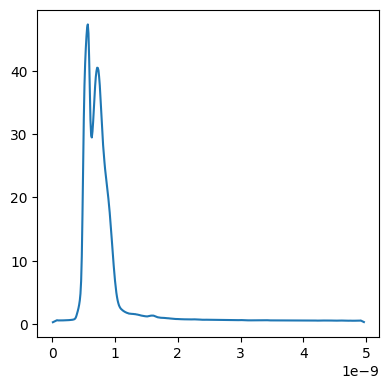

In [34]:
##########################################
fig = plt.figure(figsize = (4,4))

plt.plot(time_index[i]*1e-9,h)
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)


plt.show()

In [36]:
class calculate_miu_s1(object):
    
    def __init__(self, h, y, time_index,d):
        self.h = h
        self.y = y
        self.time = time_index
        self.d = d
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_a = x[0]
        #miu_a = 69
        miu_s = x[1]
         
        # k = 0.1
        # miu_a = 0.01e2
        g = 0.85
        # d = 0.38e-3
        d = self.d
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        # miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] ):

            intensity1[i] = calculate_miu_s1.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.intensity = intensity1
        self.y_convolved = y2
        y2 = y2/max(abs(y2))
        y3 = self.y/max(abs(self.y))
        
        return np.sum(abs(y2 - y3))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        
    def get_x(self):
        return self.intensity



In [37]:
# %%capture --no-display
miu_s_get = np.zeros((y.shape[0],2))
m1=[None]*y.shape[0]
fun_value = np.zeros((y.shape[0],))
d = 50e-3
bnds = ((0, None), (0, None))
for i in range(y.shape[0]):
    m1[i] = calculate_miu_s1(h, y[i], time_index[i+1],d)
    minu = minimize(m1[i].error_cal, x0 = [0.1e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
    miu_s_get[i], fun_value[i] = minu.x, minu.fun # Nelder-Mead

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18368\1424569783.py:9: OptimizeWarning: Unknown solver options: xtol
  minu = minimize(m1[i].error_cal, x0 = [0.1e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18368\2646682250.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  Z0 = 1/(miu_s_prime)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18368\2646682250.py:16: RuntimeWarning: invalid value encountered in double_scalars
  h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18368\2646682250.py:17: RuntimeWarning: invalid value encountered in double_scalars
  h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18368\2646682250.py:18: RuntimeWarning: invalid value encountered in double_scalars
  h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
C:\Users

Optimization terminated successfully.
         Current function value: 12.293607
         Iterations: 91
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 26.687934
         Iterations: 90
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 32.809680
         Iterations: 99
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: 21.306527
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 13.354193
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 12.346048
         Iterations: 76
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 19.813999
         Iterations: 80
         Function evaluations: 151
Optimization termina

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18368\1424569783.py:9: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  minu = minimize(m1[i].error_cal, x0 = [0.1e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})


Optimization terminated successfully.
         Current function value: 14.334624
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 12.260707
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 30.652783
         Iterations: 134
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: 20.567915
         Iterations: 157
         Function evaluations: 310
Optimization terminated successfully.
         Current function value: 26.973697
         Iterations: 89
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 21.579919
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 32.342623
         Iterations: 102
         Function evaluations: 187
Optimization term

In [39]:
miu_s_get

array([[6.78637857e+00, 1.95568953e+03],
       [6.63009402e+00, 2.66075585e+03],
       [9.09263789e+00, 3.30957983e+03],
       [9.39146087e+00, 3.15252395e+03],
       [7.81960801e+00, 2.43636681e+03],
       [9.02022574e+00, 2.59219407e+03],
       [6.69096237e+00, 2.29240758e+03],
       [1.12307755e+01, 2.69480092e+03],
       [9.00626702e+00, 3.63284550e+03],
       [1.06124788e+01, 2.15921881e+03],
       [6.27024786e+00, 2.20128158e+03],
       [8.37730765e+00, 2.43545831e+03],
       [1.26285021e+01, 3.60157346e+03],
       [7.88965859e+00, 2.27491633e+03],
       [5.63882610e+00, 2.89227350e+03],
       [8.78200949e+00, 2.85617188e+03],
       [7.97039946e+00, 2.12016283e+03],
       [8.36034014e+00, 3.14612008e+03],
       [7.94452241e+00, 2.20847940e+03],
       [7.65079287e+00, 2.55847964e+03],
       [6.99049071e+00, 1.99226798e+03],
       [4.55553065e+00, 2.18957502e+03],
       [8.76814378e+00, 2.50536577e+03],
       [6.87569851e+00, 2.43797593e+03],
       [7.522776

In [41]:
np.sum(miu_s_get[:,1]/miu_s_get.shape[0])

2573.682421488869

In [45]:
np.sum(np.max(y,1))/y.shape[0]

0.0404076867816092

In [29]:
# %%capture --no-display
miu = np.zeros((2,2))
miu = np.array([[83.21829252, 9789.38773514],[104.08146906,  9540.58548081]])
m2=[None]*2
d = np.array([1.3,3])*1e-3
yk0 = np.zeros((2,959))
for i in range(2):
    m2[i] = calculate_miu_s1(h[i], y[i], time_index[0],d[i])
    m2[i].error_cal([miu[i,0],miu[i,1]])
    yk0[i] = m2[i].get_convolved_signal()

6.232967532058431
[2.67471907 3.55824846]


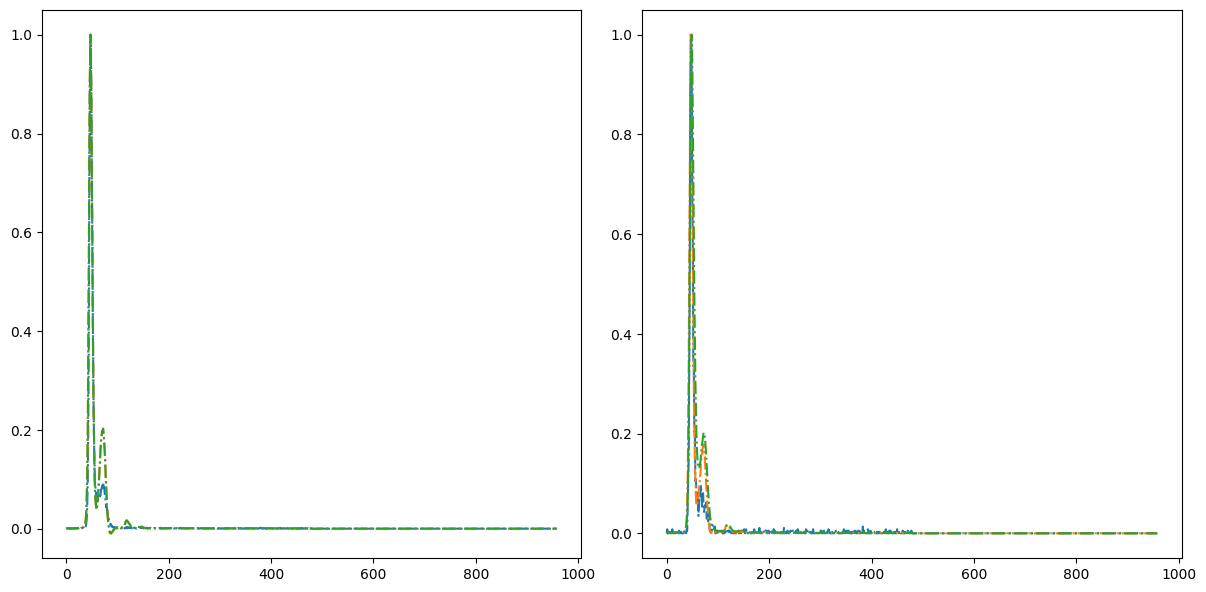

In [30]:
print(np.sum(abs(fun_value)))
print(fun_value)
plt.figure(figsize = (18,6))
yk1 = np.zeros((2,959))

for i in range (2):
    yk1[i] = m1[i].get_convolved_signal()

for i in range(2):
    plt.subplot(1,3,i+1)
    plt.plot(y[i,:]/max(abs(y[i,:])),'-.')
    plt.plot(yk1[i]/max(abs(yk1[i])),'-.')
    plt.plot(yk0[i]/max(abs(yk0[i])),'-.')
    
plt.tight_layout(pad=1.0)
plt.show()